In [1]:
import time
import math, os

from coffea.nanoevents import BaseSchema

import awkward as ak
import numpy as np
from coffea import processor

from hist import Hist

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

import matplotlib.pyplot as plt

In [2]:
## Particle collections

# Gen particle collections
gen_part_cols = ['GenPart_eta', 'GenPart_genPartIdxMother', 'GenPart_mass', 'GenPart_pdgId', "GenPart_phi", "GenPart_pt", 'GenPart_status',
                 'GenPart_Id', 'GenPart_parpdgId', 'GenPart_sparpdgId', 'GenPart_numberOfDaughters', 'GenPart_nstchgdaug', 'GenPart_vx', 
                 'GenPart_vy', 'GenPart_vz', 'GenPart_mvx', 'GenPart_mvy', 'GenPart_mvz', 'GenPart_recIdx']

# Dstar collections
dstar_cols = ['Dstar_pt', 'Dstar_eta', 'Dstar_phi', 'Dstar_rap', 'Dstar_deltam', 'Dstar_deltamr', 'Dstar_vtxIdx', 'Dstar_hasMuon',
              'Dstar_D0pt', 'Dstar_D0eta', 'Dstar_D0phi', 'Dstar_D0mass', 'Dstar_D0chi2', 'Dstar_D0dl', 'Dstar_D0dlErr',
              'Dstar_D0dlSig', 'Dstar_D0cosphi', 'Dstar_D0x', 'Dstar_D0y', 'Dstar_D0z',
              'Dstar_Kpt', 'Dstar_Keta', 'Dstar_Kphi', 'Dstar_KvtxIdx', 'Dstar_Kchindof', 'Dstar_KnValid', 'Dstar_KnPix', 'Dstar_Kdxy',
              'Dstar_Kdz', 'Dstar_Kchg',
              'Dstar_pipt', 'Dstar_pieta', 'Dstar_piphi', 'Dstar_pivtxIdx', 'Dstar_pichindof', 'Dstar_pinValid', 'Dstar_pinPix',
              'Dstar_pidxy', 'Dstar_pidz', 'Dstar_pichg',
              'Dstar_pispt', 'Dstar_piseta', 'Dstar_pisphi', 'Dstar_pisvtxIdx', 'Dstar_pischindof', 'Dstar_pisnValid', 'Dstar_pisnPix',
              'Dstar_pisdxy', 'Dstar_pisdz', 'Dstar_simIdx']

D0_PDG_MASS = 1.864

# Function to get the collections
def get_vars_dict(events, col_list):
    dict = {}
    col = ''
    for c in col_list:
        if c.startswith('Muon'):
            col = c[5:]
        elif c.startswith('Dimu'):
            col = c[4:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('D0'):
            col = c[2:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('Dstar'):
            col = c[5:]
            if col.startswith('_'): col = col[1:]
        elif c.startswith('PVtx'):
            col = c[5:]
        elif c.startswith("GenPart"):
            col = c[8:]
        else:
            Exception('Not good!')

        if col == 'x' or col == 'y' or col == 'z':
            col = 'vtx_' + col

        if len(events[c]) == 0:
            dict[col] = np.array([])
        else:
            dict[col] = events[c]
    return dict

In [3]:
files = []
# Uses scandir to iterate over the root files
with os.scandir("/eos/user/m/mabarros/Monte_Carlo/dstar_gun/0000") as it:
    # Iterates over the files
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            # Stores the file
            files.append(file.path)

In [4]:
import re

files = []
# Uses scandir to iterate over the root files
with os.scandir("/eos/user/m/mabarros/Monte_Carlo/dstar_gun/0000") as it:
    # Iterates over the files
    for file in it:
        if file.name.endswith('.root') and (file.stat().st_size != 0):
            # Stores the file
            files.append(file.path)

## Code block to sort file names
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]
            
files.sort(key=natural_keys)

In [5]:
import matplotlib.pyplot as plt
import mplhep
from matplotlib.text import Text
from hist.intervals import ratio_uncertainty

plt.style.use(mplhep.style.CMS)
    
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

In [6]:
def acceptance_plot(hist_reco, hist_gen, ax=None, with_labels=True):

    ratio = hist_reco / hist_gen.values()

    if with_labels:
        err_down, err_up = ratio_uncertainty(hist_reco.values(), hist_gen.values())
        labels = []
        for ra, u, d in zip(ratio.values().ravel(), err_up.ravel(), err_down.ravel()):
            ra, u, d = f'{ra:.2f}', f'{u:.2f}', f'{d:.2f}'
            st = '$'+ra+'_{-'+d+'}^{+'+u+'}$'
            labels.append(st)
        labels = np.array(labels).reshape(10,10)

        mplhep.hist2dplot(ratio, labels=labels, ax=ax)

        x = ax.get_children()
        for i0 in x:
            if isinstance(i0, Text):
                i0.set_size(10)

        return ax
    else:
        mplhep.hist2dplot(ratio, ax=ax)
        return ax

In [7]:
class AcceptanceProcessor(processor.ProcessorABC):
    def __init__(self):
        Gen_Dstar_hists = {
            'Gen_Dstar_pt': Hist.new.Reg(100, 0, 100, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]").Double(),
            'Gen_Dstar_eta': Hist.new.Reg(60, -4, 4, name="eta", label=r"$\eta_{D^* Gen}$").Double(),
            'Gen_Dstar_phi': Hist.new.Reg(60, -math.pi, math.pi, name="phi", label=r"$\phi_{D^* Gen}$").Double(),
            'Gen_Dstar_deltam': Hist.new.Reg(50, 0.138, 0.162, name="deltam", label=r"$\Delta m_{D^* Gen}$ [GeV]").Double(),
            
            'Gen_Dstar_pt_0to100_x_eta-4to4': (
                Hist.new
                .Reg(10, 0, 100, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]")
                .Reg(10, -4, 4, name="eta", label=r"$\eta_{D^* Gen}$")
                .Double()
                ),
            'Gen_Dstar_pt_0to100_x_eta-2p5to2p5': (
                Hist.new
                .Reg(10, 0, 100, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]")
                .Reg(10, -2.5, 2.5, name="eta", label=r"$\eta_{D^* Gen}$")
                .Double()
                ),
            'Gen_Dstar_pt_0to10_x_eta-2p5to2p5': (
                Hist.new
                .Reg(10, 0, 10, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]")
                .Reg(10, -2.5, 2.5 , name="eta", label=r"$\eta_{D^* Gen}$")
                .Double()
                ),
            'Gen_Dstar_pt_0to10_x_eta0to2p5': (
                Hist.new
                .Reg(10, 0, 10, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]")
                .Reg(10, 0, 2.5 , name="eta", label=r"$|\eta_{D^* Gen}|$")
                .Double()
                ),
            'Gen_Dstar_pt_0to30_x_eta0to2p5': (
                Hist.new
                .Reg(10, 0, 2.5 , name="eta", label=r"$|\eta_{D^* Gen}|$")
                .Reg(10, 0, 30, name='pt', label=r"$p_{T,D^* Gen}$ [GeV]")
                .Double()
                ),
            
        }

        Reco_Dstar_hists = {
            'Reco_Dstar_pt': Hist.new.Reg(100, 0, 100, name='pt', label=r"$p_{T,D^*}$ [GeV]").Double(),
            'Reco_Dstar_eta': Hist.new.Reg(60, -4, 4, name="eta", label=r"$\eta_{D^*}$").Double(),
            'Reco_Dstar_phi': Hist.new.Reg(60, -math.pi, math.pi, name="phi", label=r"$\phi_{D^*}$").Double(),
            'Reco_Dstar_deltam': Hist.new.Reg(50, 0.138, 0.162, name="deltam", label=r"$\Delta m_{D^*}$ [GeV]").Double(),
            
            'Reco_Dstar_pt_0to100_x_eta-4to4': (
                Hist.new
                .Reg(10, 0, 100, name='pt', label=r"$p_{T,D^*}$ [GeV]")
                .Reg(10, -4, 4, name="eta", label=r"$\eta_{D^*}$")
                .Double()
                ),
            'Reco_Dstar_pt_0to100_x_eta-2p5to2p5': (
                Hist.new
                .Reg(10, 0, 100, name='pt', label=r"$p_{T,D^*}$ [GeV]")
                .Reg(10, -2.5, 2.5, name="eta", label=r"$\eta_{D^*}$")
                .Double()
                ),
            'Reco_Dstar_pt_0to10_x_eta-2p5to2p5': (
                Hist.new
                .Reg(10, 0, 10, name='pt', label=r"$p_{T,D^*}$ [GeV]")
                .Reg(10, -2.5, 2.5, name="eta", label=r"$\eta_{D^*}$")
                .Double()
                ),
            'Reco_Dstar_pt_0to10_x_eta0to2p5': (
                Hist.new
                .Reg(10, 0, 10, name='pt', label=r"$p_{T,D^*}$ [GeV]")
                .Reg(10, 0, 2.5, name="eta", label=r"$|\eta_{D^*}|$")
                .Double()
                ),
            'Reco_Dstar_pt_0to30_x_eta0to2p5': (
                Hist.new
                .Reg(10, 0, 2.5, name="eta", label=r"$|\eta_{D^*}|$")
                .Reg(10, 0, 30, name='pt', label=r"$p_{T,D^*}$ [GeV]")
                .Double()
                ),
        }
        
        self._hists = {
            'Gen_Dstar': {**Gen_Dstar_hists},
            'Reco_Dstar': {**Reco_Dstar_hists},
        }
        
        self._accumulator = processor.dict_accumulator({
            'details': processor.defaultdict_accumulator(int),
        })
        
        
    @property
    def accumulator(self):
        return self._accumulator
    
    @property
    def hists(self):
        return self._hists
    

    def process(self, events):
        output = self.accumulator.identity()
        
        # test if there is any events in the file
        if len(events) == 0:
            return output

        # Collection extraction
        GenPart = ak.zip({**get_vars_dict(events, gen_part_cols)}, with_name="PtEtaPhiMCandidate")
        
        # Gen_Ds
        GenPart_D0 = GenPart[np.absolute(GenPart.pdgId) == 421]
        GenPart_Dstar = GenPart[np.absolute(GenPart.pdgId) == 413]

        # Save N of objs
        output['details']['n_Gen_Dstar'] += ak.sum(ak.num(GenPart_Dstar))
        output['details']['n_Gen_D0'] += ak.sum(ak.num(GenPart_D0))

        # Create histos
        self.hists['Gen_Dstar']['Gen_Dstar_pt'].fill(pt=ak.flatten(GenPart_Dstar.pt))
        self.hists['Gen_Dstar']['Gen_Dstar_eta'].fill(eta=ak.flatten(GenPart_Dstar.eta))
        self.hists['Gen_Dstar']['Gen_Dstar_phi'].fill(phi=ak.flatten(GenPart_Dstar.phi))
        self.hists['Gen_Dstar']['Gen_Dstar_deltam'].fill(deltam=ak.flatten(GenPart_Dstar.mass - D0_PDG_MASS))
        

        Dstar = ak.zip({'mass': (events.Dstar_D0mass + events.Dstar_deltamr),
                        'charge': events.Dstar_pischg,
                        **get_vars_dict(events, dstar_cols)}, 
                        with_name="PtEtaPhiMCandidate")
        Dstar = Dstar[~(Dstar.Kchg == Dstar.pichg)]
        Dstar = Dstar[~Dstar.hasMuon]
        Dstar = Dstar[(Dstar.deltamr > 0.14) & (Dstar.deltamr < 0.15)]

        self.hists['Reco_Dstar']['Reco_Dstar_pt'].fill(pt=ak.flatten(Dstar.pt))
        self.hists['Reco_Dstar']['Reco_Dstar_eta'].fill(eta=ak.flatten(Dstar.eta))
        self.hists['Reco_Dstar']['Reco_Dstar_phi'].fill(phi=ak.flatten(Dstar.phi))
        self.hists['Reco_Dstar']['Reco_Dstar_deltam'].fill(deltam=ak.flatten(Dstar.deltamr))
        
        ## Hist: from 0 to 100 GeV and from -4 to 4 in eta  
        self.hists['Gen_Dstar']['Gen_Dstar_pt_0to100_x_eta-4to4'].fill(
            pt=ak.flatten(GenPart_Dstar.pt),
            eta=ak.flatten(GenPart_Dstar.eta)
            )
        self.hists['Reco_Dstar']['Reco_Dstar_pt_0to100_x_eta-4to4'].fill(
            pt=ak.flatten(Dstar.pt),
            eta=ak.flatten(Dstar.eta)
            )
        ## Hist: from 0 to 100 GeV and from -2;5 to 2.5 in eta  
        self.hists['Gen_Dstar']['Gen_Dstar_pt_0to100_x_eta-2p5to2p5'].fill(
            pt=ak.flatten(GenPart_Dstar.pt),
            eta=ak.flatten(GenPart_Dstar.eta)
            )
        self.hists['Reco_Dstar']['Reco_Dstar_pt_0to100_x_eta-2p5to2p5'].fill(
            pt=ak.flatten(Dstar.pt),
            eta=ak.flatten(Dstar.eta)
            )
        
        ## Hist: from 0 to 10 GeV and from -2.5 to 2.5 in eta    
        self.hists['Gen_Dstar']['Gen_Dstar_pt_0to10_x_eta-2p5to2p5'].fill(
            pt=ak.flatten(GenPart_Dstar.pt),
            eta=ak.flatten(GenPart_Dstar.eta)
            )
              
        self.hists['Reco_Dstar']['Reco_Dstar_pt_0to10_x_eta-2p5to2p5'].fill(
            pt=ak.flatten(Dstar.pt),
            eta=ak.flatten(Dstar.eta)
            )
        
        ## Hist: from 0 to 10 GeV and from 0 to 2.5 in eta    
        self.hists['Gen_Dstar']['Gen_Dstar_pt_0to10_x_eta0to2p5'].fill(
            pt=ak.flatten(GenPart_Dstar.pt),
            eta=ak.flatten(np.absolute(GenPart_Dstar.eta))
            )
              
        self.hists['Reco_Dstar']['Reco_Dstar_pt_0to10_x_eta0to2p5'].fill(
            pt=ak.flatten(Dstar.pt),
            eta=ak.flatten(np.absolute(Dstar.eta))
            )
        
        ## Hist: from 0 to 30 GeV and from 0 to 2.5 in eta    
        self.hists['Gen_Dstar']['Gen_Dstar_pt_0to30_x_eta0to2p5'].fill(
            pt=ak.flatten(GenPart_Dstar.pt),
            eta=ak.flatten(np.absolute(GenPart_Dstar.eta))
            )
              
        self.hists['Reco_Dstar']['Reco_Dstar_pt_0to30_x_eta0to2p5'].fill(
            pt=ak.flatten(Dstar.pt),
            eta=ak.flatten(np.absolute(Dstar.eta))
            )

        return self.hists

    def postprocess(self, accumulator):
        return accumulator

In [8]:
data = {"test": files[:100]}

tstart = time.time()

output = processor.run_uproot_job(data,
                                    treename='Events',
                                    processor_instance=AcceptanceProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={"schema": BaseSchema, 'workers': 8, 'skipbadfiles': True},
                                    chunksize=360000,
                                    )

""" hists = output[1]
output = output[0] """

print(f"Process finished in: {time.time() - tstart:.2f} s")
#print(output[0]['details'])

Preprocessing:   0%|          | 0/100 [00:00<?, ?file/s]

Processing:   0%|          | 0/100 [00:00<?, ?chunk/s]

Process finished in: 58.28 s


In [9]:
## 2D plot: 0 < pT < 100 GeV; -4 < eta < 4

fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Dstar']['Reco_Dstar_pt_0to100_x_eta-4to4'], output['Gen_Dstar']['Gen_Dstar_pt_0to100_x_eta-4to4'], ax=ax)
ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
ax.set_ylabel(r"$\eta_{D^{*}}$")

Text(0, 1, '$\\eta_{D^{*}}$')

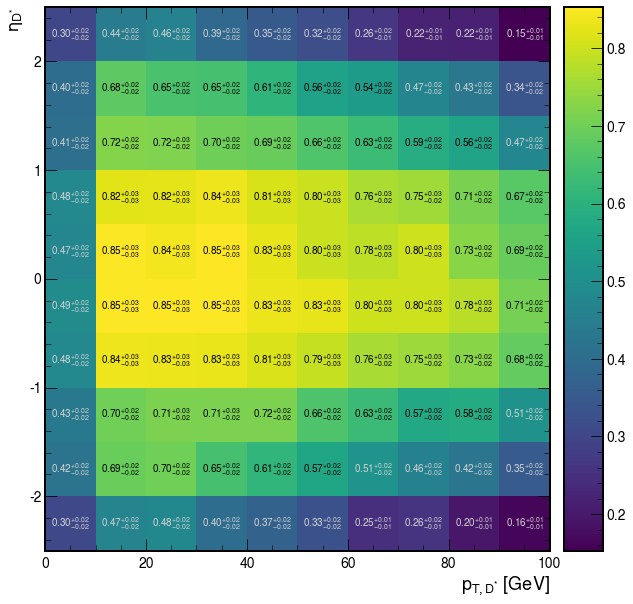

In [10]:
## 2D plot: 0 < pT < 100 GeV; -2.5 < eta < 2.5

fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Dstar']['Reco_Dstar_pt_0to100_x_eta-2p5to2p5'], output['Gen_Dstar']['Gen_Dstar_pt_0to100_x_eta-2p5to2p5'], ax=ax)
ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
ax.set_ylabel(r"$\eta_{D^{*}}$")

In [ ]:
## 2D plot: 0 < pT < 10; -2.5 < eta < 2.5

fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Dstar']['Reco_Dstar_pt_0to10_x_eta-2p5to2p5'], output['Gen_Dstar']['Gen_Dstar_pt_0to10_x_eta-2p5to2p5'], ax=ax)
ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
ax.set_ylabel(r"$\eta_{D^{*}}$")

<AxesSubplot:xlabel='$p_{T,D^*}$ [GeV]', ylabel='$|\\eta_{D^*}|$'>

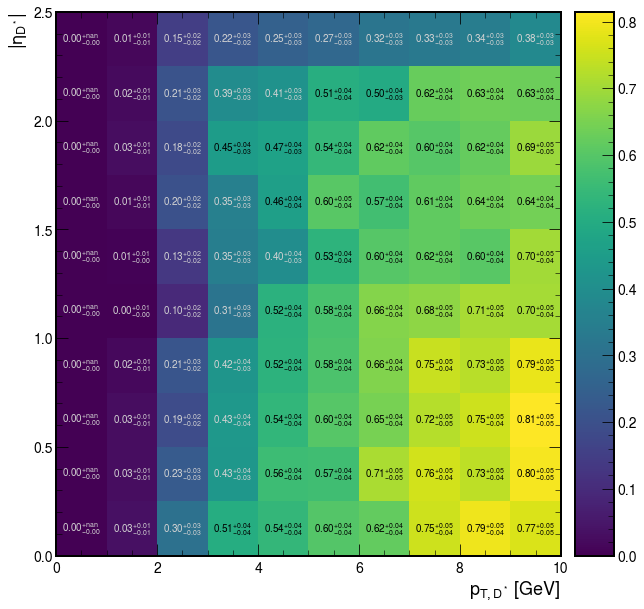

In [31]:
## 2D plot: 0 < pT < 10; |n| < 2.5  
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Dstar']['Reco_Dstar_pt_0to10_x_eta0to2p5'], output['Gen_Dstar']['Gen_Dstar_pt_0to10_x_eta0to2p5'], ax=ax)
#ax.set_xlabel(r"$p_{T,D^{*}}$ [GeV]")
#ax.set_ylabel(r"$\eta_{D^{*}}$")

<AxesSubplot:xlabel='$|\\eta_{D^*}|$', ylabel='$p_{T,D^*}$ [GeV]'>

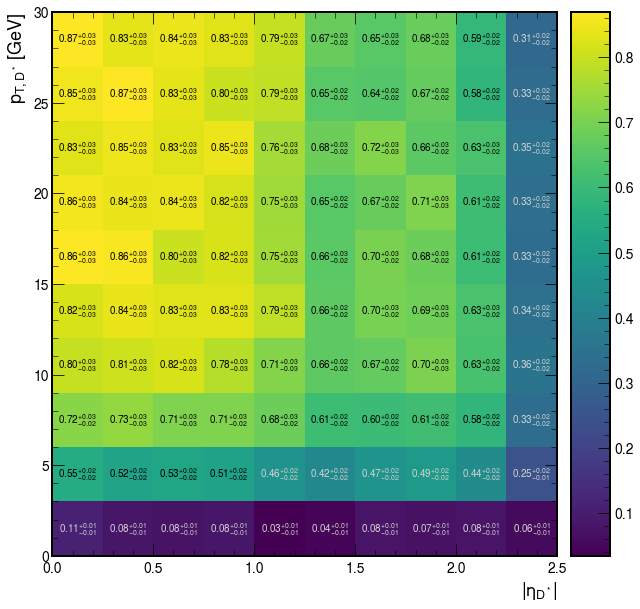

In [30]:
## 2D plot: 0 < pT < 30; |n| < 2.5  
fig = plt.figure()
fig.clear()
ax = fig.add_subplot()
acceptance_plot(output['Reco_Dstar']['Reco_Dstar_pt_0to30_x_eta0to2p5'], output['Gen_Dstar']['Gen_Dstar_pt_0to30_x_eta0to2p5'], ax=ax)